# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Web-Scraping"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Web Scraping</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span></a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span></a></div></p>

In [1]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.
URL_top_uni = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508076958348'
URL_top_uni2 = 'https://www.topuniversities.com'
URL_tim_high = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

## Task 1. Web Scraping

The `DATA_FOLDER/final_df.pkl` is a pickle files that contains all the extracted data from www.topuniversities.com. We decided to store our data in a file because collecting data from that website required a lot of time. Doing this way we can load everything in a small time.

### Useful functions

#### Here we introduce and explain some useful functions that we made for handling the datasets:

<ul>
<li> convert_to_numbers(string): <p>It simply takes a string and returns only the digit as a float

<li> retrieve_university_data(url, list_, university_name): <p>Explain

<li> clean_matches(names, matches, outliers_list): <p>After matching the names of the two universities with difflib.get_close_matches, we observed that a lot of errors occured during the execution of this last function. So we created clean_matches() in order to "clean" all these errors. It takes as parameters two series, the first one is the series containing the names of the universities from one of the two websites (ex: top universities), the second one is the corresponding match (ex: the match found in times higher education of the name Oxford from top universities). The third parameter is a list of strings that can be substrings of the elements of names and matches: we replace these substrings with "" if we find them because they increase the percentage of finding a good match when it is not. For example: "The Technological University of ADA" is very similar to "The Technological University of Bob", but if we delete the substring "The Technological University of" the two remaining strings will be very different and so we can notice that the match was wrong. It returns a dataframe with two columns: the name column as it was given and the match column cleaned of all the errors (NaN filling the wrong values). For more details, please look at the comments in the code.


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from numpy import NaN
import re
import matplotlib.pyplot as plt
import difflib

def convert_to_numbers(string):
    return pd.to_numeric(re.sub("\D", "", string))


def retrieve_university_data(url, list_, university_name):

    req = requests.get(url)
    soup = BeautifulSoup(req.text, 'html.parser')

    faculty_staff_wrapper = soup.find('div', class_='faculty-main')

    if faculty_staff_wrapper:

        total_staff = convert_to_numbers(faculty_staff_wrapper.find('div', class_ = 'total').find('div', class_ = 'number').text)
        international_staff = faculty_staff_wrapper.find('div', class_='inter')
        if international_staff:
            international_staff = convert_to_numbers(international_staff.find('div', class_ = 'number').text)
        else:
            international_staff = NaN
    else:
        total_staff = NaN
        international_staff = NaN

    total_students_wrapper = soup.find('div', class_='students-main')

    if total_students_wrapper:

        total_students = convert_to_numbers(total_students_wrapper.find('div', class_ = 'total').find('div', class_ = 'number').text)
    else:
        total_students = NaN

    international_students_wrapper = soup.find('div', class_='int-students-main')
    if international_students_wrapper:
        international_students = convert_to_numbers(international_students_wrapper.find('div', class_='total').find('div', class_ = 'number').text)

    else:
        international_students = NaN

    list_.append({'title': university_name,
                              'international_staff': international_staff,
                              'total_staff': total_staff,
                              'international_students': international_students,
                              'total_students': total_students})


def clean_matches(names, matches, outliers_list):

    final_df = pd.DataFrame()

    '''
    The word "The" is replaced in every name since it is not particular of any university
    '''
    for name, match in zip(names, matches):
        if 'The ' in name:
            name = name.replace('The ', '')
            #Why not match.replace????

        outliers_found_list = []

        '''
        If we find one outlier in both the match and the name, we append it to the list of outliers found
        '''
        for elem in outliers_list:
            if match is not NaN and elem in name and elem in match:
                outliers_found_list.append(elem)

        '''
        We retrive the longest outlier in order to replace it with ""
        '''
        if len(outliers_found_list) > 0:
            longest_out = max(outliers_found_list, key=len)

            '''
            The longest outlier is splitted in all the words that is made of
            '''
            splitted = longest_out.split()

            temp_name = name
            temp_match = match
            
            '''
            We get the new strings without the outlier
            '''
            for word in splitted:
                temp_name = temp_name.replace(word, '')
                temp_match = temp_match.replace(word, '')


            '''
            We cancel everything inside the parenthesis because is not useful.
            We are deleting every possible abbreviation of the universities
            '''
            start_name = temp_name.find('(')
            start_match = temp_match.find('(')
            end_name = temp_name.find(')')
            end_match = temp_match.find(')')

            if start_name != -1 and end_name != -1:
                temp_name = temp_name.replace(temp_name[start_name: end_name +1], '')


            if start_match != -1 and end_match != -1:
                temp_match = temp_match.replace(temp_match[start_match: end_match + 1], '')


            '''
            If after all these steps the match is good at least for the 86%, we keep it.
            We chose the percentage (86%) empirically. This percentage gives us a perfect match everywhere.
            If the match is under the threshold, we put NaN instead of the match
            '''
            if difflib.SequenceMatcher(None, temp_name, temp_match).ratio() > 0.86:
                new_row = pd.Series([name, match])
                final_df = final_df.append(new_row, ignore_index=True)
            else:
                new_row = pd.Series([name, NaN])
                final_df = final_df.append(new_row, ignore_index=True)
            
            '''
            If we didn't find any outlier then the match was good 
            (only names containg outliers gave problems of wrong matches)
            '''
        else:
            new_row = pd.Series([name, match])
            final_df = final_df.append(new_row, ignore_index=True)
        


    final_df.columns = ['name', 'match']

    return final_df

### Top Universities Scraping

#### Actual web scraping

This is the script that retrieves all the data from the website. It takes several minutes to find everything we need, so if you want to try it, let it run, go and grab a cup of coffee!

In [3]:
# URL_top_uni = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508076958348'
#
# r = requests.get(URL_top_uni)
#
# dataframe = pd.DataFrame(r.json())
#
# dict = dataframe['data']
#
# dataframe = pd.concat([dataframe, dict.apply(pd.Series)], axis=1)
#
# dataframe = dataframe.drop('data', axis = 1)
#
# dataframe1 = dataframe[['country', 'region', 'title', 'rank_display', 'url', 'guide']]
#
# dataframe1.loc[:,'rank_display'] = dataframe1.rank_display.str.extract('(\d+)').astype(int)
#
# dataframe1 = dataframe1.head(200)
#
# URL_top_uni2 = 'https://www.topuniversities.com'
#
# temp_list = []
# for name, url in zip(dataframe1.title, dataframe1.url):
#
#     retrieve_university_data(URL_top_uni2 + url, temp_list, name)
#
# second_df = pd.DataFrame.from_dict(temp_list)
#
# tu_df = dataframe1.merge(second_df, left_on ='title', right_on ='title', how ='outer')
#
# tu_df = tu_df[['country', 'region', 'title', 'rank_display', 'international_staff', 'total_staff', 'international_students', 'total_students']]
#
# tu_df.to_pickle('final_df.pkl')

We read the pickle file in tu_df, we set the index and then we rename every columns with the prefix TU (Top Universities). Then we calculate the ratio between staff and students and between internation students and total students

In [4]:
tu_df = pd.read_pickle('Data/final_df.pkl')

tu_df = tu_df.set_index('title')

columns_dict = {'country' : 'TU_country', 'region' : 'TU_region', 'rank_display' : 'TU_rank',
                'international_staff' : 'TU_international_staff', 'total_staff' : 'TU_total_staff',
                'international_students' : 'TU_international_students', 'total_students' : 'TU_total_students'}

tu_df = tu_df.rename(columns = columns_dict)

tu_df.index.name = 'name'

tu_df['TU_ratio_staff_students'] = tu_df.TU_total_staff / tu_df.TU_total_students
tu_df['TU_ratio_international_students'] = tu_df.TU_international_students / tu_df.TU_total_students

In [5]:
tu_df.head(4)

,TU_country,TU_region,TU_rank,TU_international_staff,TU_total_staff,TU_international_students,TU_total_students,TU_ratio_staff_students,TU_ratio_international_students
name,,,,,,,,,
Massachusetts Institute of Technology (MIT),United States,North America,1,1679.0,2982.0,3717.0,11067.0,0.269450,0.335863
Stanford University,United States,North America,2,2042.0,4285.0,3611.0,15878.0,0.269870,0.227422
Harvard University,United States,North America,3,1311.0,4350.0,5266.0,22429.0,0.193945,0.234785
California Institute of Technology (Caltech),United States,North America,4,350.0,953.0,647.0,2255.0,0.422616,0.286918


Ordering the tu_df in two different ways: for descending values of ratio staff/students and of international/total_students

In [6]:
df_ratio_staff_students = tu_df.sort_values('TU_ratio_staff_students', ascending=False)
df_ratio_intern_students = tu_df.sort_values('TU_ratio_international_students', ascending=False)

df_ratio_staff_students.head(4)

,TU_country,TU_region,TU_rank,TU_international_staff,TU_total_staff,TU_international_students,TU_total_students,TU_ratio_staff_students,TU_ratio_international_students
name,,,,,,,,,
California Institute of Technology (Caltech),United States,North America,4,350.0,953.0,647.0,2255.0,0.422616,0.286918
Yale University,United States,North America,16,1708.0,4940.0,2469.0,12402.0,0.398323,0.199081
University of Oxford,United Kingdom,Europe,6,2964.0,6750.0,7353.0,19720.0,0.342292,0.372870
University of Cambridge,United Kingdom,Europe,5,2278.0,5490.0,6699.0,18770.0,0.292488,0.356899


### Times Higher Education Scraping

We make a request to the url containing all the data. It is a json file, and we put it in the variable page_body. Then we create a dataframe with those data and we rename the columns as we preferred. Finally, we take only the columns we need.

In [7]:
r = requests.get(URL_tim_high)
page_body = r.json()

the_df = pd.DataFrame.from_records(page_body.get("data"))


# Missing region and faculty members international
the_df = the_df.rename(index=str, columns={"aliases": "name2",
                                               "location": "country",
                                               "stats_number_students": "number_of_students",
                                               "stats_pc_intl_students": "int_student/total",
                                               "stats_student_staff_ratio": "student/staff"})

the_df = the_df[["name", "rank", "country", "number_of_students", "int_student/total", "student/staff"]]

We do all the common operations (transforming strings to float, replacing wrong divisors and wrong characters). Then we choose only the 200 best universities and we set the name of the universities as index of the dataframe.

In [8]:
# Inverse of the ratio from student/staff to staff/student
the_df["student/staff"] = the_df["student/staff"].apply(pd.to_numeric)
the_df["staff/student"] = 1 / the_df["student/staff"]
the_df = the_df.drop("student/staff", axis=1)

# Replacing commas with nothing (commas used as divisor of thousands)
the_df.number_of_students = the_df.number_of_students.apply(lambda x: int(x.replace(',', '')))

# Eliminating the % sign and creating percentages
the_df["int_student/total"] = the_df["int_student/total"].apply(lambda x: int(x.replace('%', '')) / 100)

# Creating the number of international students from the number of students and ratio with internationals
the_df["number_international_students"] = (the_df.number_of_students * the_df["int_student/total"]).apply(int)

# Taking only the digits from the rank column
the_df["rank"] = the_df["rank"].apply(lambda row: pd.to_numeric(re.sub("\D", "", row)))

# Choosing only the best 200 universities
the_df = the_df[:200]

# Setting the name of the university as index
the_df = the_df.set_index("name")

In [9]:
the_df.head(4)

,rank,country,number_of_students,int_student/total,staff/student,number_international_students
name,,,,,,
University of Oxford,1,United Kingdom,20409,0.38,0.089286,7755
University of Cambridge,2,United Kingdom,18389,0.35,0.091743,6436
California Institute of Technology,3,United States,2209,0.27,0.153846,596
Stanford University,3,United States,15845,0.22,0.133333,3485


Best Universities for ratio international_students/students

In [10]:
the_df.sort_values(by="int_student/total", ascending=False).head(10)

,rank,country,number_of_students,int_student/total,staff/student,number_international_students
name,,,,,,
London School of Economics and Political Science,25,United Kingdom,10065,0.71,0.081967,7146
University of Luxembourg,179,Luxembourg,4969,0.57,0.068493,2832
École Polytechnique Fédérale de Lausanne,38,Switzerland,9928,0.55,0.089286,5460
Imperial College London,8,United Kingdom,15857,0.55,0.087719,8721
Maastricht University,103,Netherlands,16727,0.50,0.055556,8363
University College London,16,United Kingdom,30304,0.49,0.095238,14848
University of St Andrews,143,United Kingdom,9005,0.48,0.076923,4322
Carnegie Mellon University,24,United States,12676,0.45,0.074074,5704
Queen Mary University of London,121,United Kingdom,15405,0.45,0.075188,6932


Best Universities for ratio international_students/students

In [11]:
the_df.sort_values(by="int_student/total", ascending=False).head(10)

,rank,country,number_of_students,int_student/total,staff/student,number_international_students
name,,,,,,
London School of Economics and Political Science,25,United Kingdom,10065,0.71,0.081967,7146
University of Luxembourg,179,Luxembourg,4969,0.57,0.068493,2832
École Polytechnique Fédérale de Lausanne,38,Switzerland,9928,0.55,0.089286,5460
Imperial College London,8,United Kingdom,15857,0.55,0.087719,8721
Maastricht University,103,Netherlands,16727,0.50,0.055556,8363
University College London,16,United Kingdom,30304,0.49,0.095238,14848
University of St Andrews,143,United Kingdom,9005,0.48,0.076923,4322
Carnegie Mellon University,24,United States,12676,0.45,0.074074,5704
Queen Mary University of London,121,United Kingdom,15405,0.45,0.075188,6932


Best Countries for ratio staff/students

In [12]:
the_df.groupby("country").mean().sort_values(by="staff/student", ascending=False).head(10)

,rank,number_of_students,int_student/total,staff/student,number_international_students
country,,,,,
Denmark,123.666667,21370.000000,0.166667,0.160166,3108.666667
Italy,169.500000,602.500000,0.105000,0.138889,66.000000
Russian Federation,194.000000,29236.000000,0.220000,0.136986,6431.000000
Japan,60.000000,24240.500000,0.090000,0.132098,2199.000000
United States,77.322581,27508.596774,0.181774,0.106390,4521.580645
France,144.833333,16563.000000,0.208333,0.099352,3162.166667
China,119.857143,36273.000000,0.085714,0.087420,3268.428571
Taiwan,198.000000,31758.000000,0.080000,0.086957,2540.000000
South Africa,171.000000,20775.000000,0.180000,0.085470,3739.000000


Best Countries for ratio international_students/students

In [13]:
the_df.groupby("country").mean().sort_values(by="int_student/total", ascending=False).head(10)

,rank,number_of_students,int_student/total,staff/student,number_international_students
country,,,,,
Luxembourg,179.000000,4969.000000,0.570000,0.068493,2832.000000
United Kingdom,110.580645,19240.290323,0.365484,0.074252,6872.419355
Hong Kong,88.600000,15532.600000,0.328000,0.056622,5031.400000
Switzerland,95.142857,15407.428571,0.314286,0.083447,4677.571429
Australia,77.000000,33578.750000,0.307500,0.038233,10475.875000
Singapore,37.000000,28050.500000,0.305000,0.060087,8542.000000
New Zealand,192.000000,30348.000000,0.290000,0.053191,8800.000000
Ireland,117.000000,16157.000000,0.270000,0.043860,4362.000000
Austria,165.000000,35375.000000,0.260000,0.048077,9197.000000


Plotting the results. Plotting the ratio staff/student and int_student/total for every universities was really messy (too many universities) so we decided to plot only the best 20. For the countries no problems.

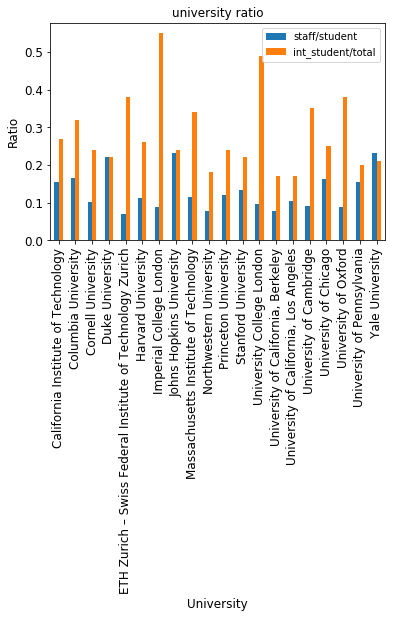

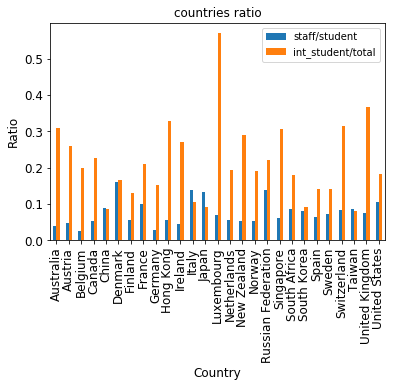

In [14]:
# ax_universities = the_df.groupby("name").mean()[["staff/student", "int_student/total"]].plot(kind='bar', title="university ratio", legend=True, fontsize=12)
# ax_universities.set_xlabel("University", fontsize=12)
# ax_universities.set_ylabel("Ratio", fontsize=12)
# plt.show()

ax_universities = the_df[:20].groupby("name").mean()[["staff/student", "int_student/total"]].plot(kind='bar', title="university ratio", legend=True, fontsize=12)
ax_universities.set_xlabel("University", fontsize=12)
ax_universities.set_ylabel("Ratio", fontsize=12)
plt.show()

ax_countries = the_df.groupby("country").mean()[["staff/student", "int_student/total"]].plot(kind='bar', title="countries ratio", legend=True, fontsize=12)
ax_countries.set_xlabel("Country", fontsize=12)
ax_countries.set_ylabel("Ratio", fontsize=12)
plt.show()

Renaming the columns before the merge with the other dataframe.

In [15]:
the_df.rename(columns={"rank": "thEd_rank",
                         "number_of_students": "thEd_number_of_students",
                         "int_student/total": "thEd_int_student/total",
                         "staff/student": "thEd_staff/student",
                         "number_international_students": "thEd_number_international_students"},
              inplace=True)

the_df.head()

,thEd_rank,country,thEd_number_of_students,thEd_int_student/total,thEd_staff/student,thEd_number_international_students
name,,,,,,
University of Oxford,1,United Kingdom,20409,0.38,0.089286,7755
University of Cambridge,2,United Kingdom,18389,0.35,0.091743,6436
California Institute of Technology,3,United States,2209,0.27,0.153846,596
Stanford University,3,United States,15845,0.22,0.133333,3485
Massachusetts Institute of Technology,5,United States,11177,0.34,0.114943,3800


### Merging the Dataframes

Describe the merging below

In [16]:
nameMatch = []
for name1 in tu_df.index:
    for name2 in the_df.index:
        if name1 in name2 or name2 in name1:
            nameMatch.append(name1 + '|' + name2)


in_first = []
for name1 in tu_df.index:
    for name2 in nameMatch:
        if name1 in name2:
            in_first.append(name1)

not_in_first = []
for name_y in tu_df.index:
    if name_y not in in_first:
        not_in_first.append(name_y)

nameMatch2 = []
for namex in the_df.index:
    for name2 in nameMatch:
        if namex in name2:
            nameMatch2.append(namex)

not_in_second = []
for name_y in the_df.index:
    if name_y not in nameMatch2:
        not_in_second.append(name_y)

temp_matches = the_df.index.map(lambda x: difflib.get_close_matches(x, tu_df.index, n = 1, cutoff=0.70))
first_matches = tu_df.index.map(lambda x: difflib.get_close_matches(x, the_df.index, n = 1, cutoff=0.70))

matches = []
no_match_counter = 0
match_counter = 0
for match in temp_matches:
    if len(match) > 0:
        matches.append(match[0])
        match_counter += 1
    else:
        matches.append(NaN)
        no_match_counter +=1

first_m = []
match_counter2 = 0
for match in first_matches:
    if len(match) > 0:
        first_m.append(match[0])
        match_counter2 += 1

    else:
        first_m.append(NaN)


df_compare1 = pd.DataFrame({'first_index' : tu_df.index, 'first_match': first_m})

out_list = ['University', 'University of Technology', 'State University',
             'Institute of Technology', 'National University', 'Technical University',
             'University of ', 'University of Science and Technology', 'Vrije Universiteit']

new_df_compare1 = clean_matches(tu_df.index, df_compare1.first_match, out_list)


counter1 = 0
for result in new_df_compare1.match:
    if result is not NaN:
        counter1 +=1

tu_df = tu_df.reset_index()

column = pd.Series(new_df_compare1.match)
column = column.reindex(tu_df.index)

tu_df['matchID'] = column


new_df_compare1 = new_df_compare1[new_df_compare1.notnull().all(axis=1)].sort_values('match')
new_df_compare1.to_csv('matched_name_first_in_second.csv')

df_compare2 = pd.DataFrame({ 'second_index' : the_df.index, 'second_match': matches})

the_df['matchID'] = pd.Series(NaN, index=the_df.index)

c = 0
for name in the_df.index:
    for match in new_df_compare1.match:
        if name is match:
            the_df.loc[name, 'matchID'] = match
            c += 1

final_first_site = tu_df[['name', 'matchID']].sort_values('matchID')
tu_df = tu_df.set_index('name')

final_second_site = the_df.reset_index()[['name', 'matchID']].sort_values('matchID')


tu_df = tu_df.merge(the_df, how='outer', left_on='matchID', right_on='matchID')

tu_df = tu_df.dropna()

tu_df = tu_df.set_index('matchID')

nan_first_site = tu_df[tu_df.isnull().any(axis=1)]

nan_second_site = the_df[the_df.isnull().any(axis=1)]

tu_df = tu_df.append(nan_first_site)
tu_df = tu_df.append(nan_second_site)
tu_df = tu_df.drop('matchID', axis = 1)

In [17]:
tu_df.head()

,TU_country,TU_international_staff,TU_international_students,TU_rank,TU_ratio_international_students,TU_ratio_staff_students,TU_region,TU_total_staff,TU_total_students,country,thEd_int_student/total,thEd_number_international_students,thEd_number_of_students,thEd_rank,thEd_staff/student
Massachusetts Institute of Technology,United States,1679.0,3717.0,1.0,0.335863,0.269450,North America,2982.0,11067.0,United States,0.34,3800,11177,5,0.114943
Stanford University,United States,2042.0,3611.0,2.0,0.227422,0.269870,North America,4285.0,15878.0,United States,0.22,3485,15845,3,0.133333
Harvard University,United States,1311.0,5266.0,3.0,0.234785,0.193945,North America,4350.0,22429.0,United States,0.26,5284,20326,6,0.112360
California Institute of Technology,United States,350.0,647.0,4.0,0.286918,0.422616,North America,953.0,2255.0,United States,0.27,596,2209,3,0.153846
University of Cambridge,United Kingdom,2278.0,6699.0,5.0,0.356899,0.292488,Europe,5490.0,18770.0,United Kingdom,0.35,6436,18389,2,0.091743
